# BDTT Assignment
**Kamal Kiani**

This solution uses **Dataframe** in spark to solve the assignment tasks. 

To run the code for other years as input datasets, simply change the values for `yearOfStudy` and `clinicaltiral_filename` variables.

In [0]:
yearOfStudy = '2021'
clinicaltiral_filename = 'clinicaltrial_2021_csv.gz'

In [0]:
# importing useful packages :
from pyspark.sql.functions import desc
from pyspark.sql.functions import split
from pyspark.sql.functions import explode
from pyspark.sql.functions import lit
from pyspark.sql.functions import when

# static values definition :
bold = '\033[1m'
bold_end = '\033[0m'

In [0]:
# reading the data into dataframes :

clinicaltiral = spark.read.option("delimiter", '|').csv('dbfs:/FileStore/tables/' + clinicaltiral_filename , header=True)
mesh    = spark.read.option("delimiter", ',').csv('dbfs:/FileStore/tables/mesh.csv', header=True)
pharma  = spark.read.option("delimiter", ',').csv('dbfs:/FileStore/tables/pharma.csv', header=True)

In [0]:
# exploring the data :
clinicaltiral.limit(3).show()

+-----------+--------------------+----------+--------+----------+--------------+----------+--------------------+-------------+
|         Id|             Sponsor|    Status|   Start|Completion|          Type|Submission|          Conditions|Interventions|
+-----------+--------------------+----------+--------+----------+--------------+----------+--------------------+-------------+
|NCT02758028|The University of...|Recruiting|Aug 2005|  Nov 2021|Interventional|  Apr 2016|                null|         null|
|NCT02751957|     Duke University| Completed|Jul 2016|  Jul 2020|Interventional|  Apr 2016|Autistic Disorder...|         null|
|NCT02758483|Universidade Fede...| Completed|Mar 2017|  Jan 2018|Interventional|  Apr 2016|   Diabetes Mellitus|         null|
+-----------+--------------------+----------+--------+----------+--------------+----------+--------------------+-------------+



# Task 1 
**The number of distinct studies**

In [0]:
def numberOfStudies(myDF) : 
    return myDF.distinct().count();

In [0]:
print('Number of studies in ' + bold + yearOfStudy + bold_end + ' is: ' + bold + str(numberOfStudies(clinicaltiral)) + bold_end )

Number of studies in 2021 is: 387261


# Task 2 
**Types of studies and their frequencies**

In [0]:
def typesOfStudies(myDF) :
    temp = myDF.groupBy('Type').count().orderBy(desc('count'))
    return temp.withColumnRenamed('count','count ' + yearOfStudy)

In [0]:
print(bold + '<< Types of studies and their frequencies in ' + yearOfStudy + ' >>' + bold_end)
typesOfStudies(clinicaltiral).show(truncate=False)

<< Types of studies and their frequencies in 2021 >>
+--------------------------------+----------+
|Type                            |count 2021|
+--------------------------------+----------+
|Interventional                  |301472    |
|Observational                   |77540     |
|Observational [Patient Registry]|8180      |
|Expanded Access                 |69        |
+--------------------------------+----------+



# Task 3 
**Top 5 conditions and their frequencies**

In [0]:
def topConditions(myDF):
    splitDf = myDF.filter("Conditions is Not NULL").withColumn('spilted_conditions' , split(myDF['Conditions'],','))
    explodedDF = splitDf.withColumn('exploded_conditions', explode( splitDf['spilted_conditions'] ))
    group_condition = explodedDF.groupBy('exploded_conditions').count().orderBy(desc('count')).limit(5)
    return group_condition.withColumnRenamed('count','count ' + yearOfStudy)

In [0]:
print(bold + '<< Top 5 conditions and their frequencies in ' + yearOfStudy + ' >>' + bold_end)
topConditions(clinicaltiral).show(truncate=False)    

<< Top 5 conditions and their frequencies in 2021 >>
+-------------------+----------+
|exploded_conditions|count 2021|
+-------------------+----------+
|Carcinoma          |13389     |
|Diabetes Mellitus  |11080     |
|Neoplasms          |9371      |
|Breast Neoplasms   |8640      |
|Syndrome           |8032      |
+-------------------+----------+



# Task 4 
**The 5 most frequent roots**

In [0]:
def frequentRoots(myDF):    
    mesh_code = mesh.withColumn('tree_id',split(mesh['tree'],'\.')[0])
    splitDf = myDF.filter("Conditions is Not NULL").withColumn('spilted_conditions' , split(myDF['Conditions'],','))
    explodedDF = splitDf.withColumn('exploded_conditions', explode( splitDf['spilted_conditions'] ))   
    temp = explodedDF.join(mesh_code , mesh_code.term ==  explodedDF.exploded_conditions,'inner')
    return temp.groupBy('tree_id').count().orderBy(desc('count')).limit(5).withColumnRenamed('count','count ' + yearOfStudy)    

In [0]:
print(bold + '<< The 5 most frequent roots in ' + yearOfStudy + ' >>' + bold_end)
frequentRoots(clinicaltiral).show(truncate=False)  

<< The 5 most frequent roots in 2021 >>
+-------+----------+
|tree_id|count 2021|
+-------+----------+
|C04    |143994    |
|C23    |136079    |
|C01    |106674    |
|C14    |94523     |
|C10    |92310     |
+-------+----------+



# Task 5 
**10 most common sponsors that are not pharmaceutical companies, along with the number of clinical trials they have sponsored**

In [0]:
def getSponsors(myDF):  
    pharmaceutical_companies = pharma.distinct().rdd.map(lambda item: item.Parent_Company).collect()
    non_pharmaceutical_companies = myDF.filter(myDF.Sponsor.isin(pharmaceutical_companies) == False)
    temp = non_pharmaceutical_companies.groupBy('Sponsor').count().orderBy(desc('count')).limit(10)
    return temp.withColumnRenamed('count','count ' + yearOfStudy)

In [0]:
print(bold + '<< non pharmaceutical sponsors, and sponsored clinical trials in ' + yearOfStudy + ' >>' + bold_end)
getSponsors(clinicaltiral).show(truncate=False) 

<< non pharmaceutical sponsors, and sponsored clinical trials in 2021 >>
+---------------------------------------+----------+
|Sponsor                                |count 2021|
+---------------------------------------+----------+
|National Cancer Institute (NCI)        |3218      |
|M.D. Anderson Cancer Center            |2414      |
|Assistance Publique - Hôpitaux de Paris|2369      |
|Mayo Clinic                            |2300      |
|Merck Sharp & Dohme Corp.              |2243      |
|Assiut University                      |2154      |
|Novartis Pharmaceuticals               |2088      |
|Massachusetts General Hospital         |1971      |
|Cairo University                       |1928      |
|Hoffmann-La Roche                      |1828      |
+---------------------------------------+----------+



# Task 6 
**Number of completed studies each month in a given year**

In [0]:
def compeletedStudies(myDF):
    temp = myDF.where("status ='Completed'") \
        .withColumn('month', split(myDF['Completion'],' ')[0])\
        .withColumn('year', split(myDF['Completion'],' ')[1])
    t2 = temp.where('year= ' + yearOfStudy).groupBy('month' ).count() 
    result = t2.withColumn('month_order', \
      when((t2.month == 'Jan'), lit(1)) \
     .when((t2.month == 'Feb'), lit(2)) \
     .when((t2.month == 'Mar'), lit(3)) \
     .when((t2.month == 'Apr'), lit(4)) \
     .when((t2.month == 'May'), lit(5)) \
     .when((t2.month == 'Jun'), lit(6)) \
     .when((t2.month == 'Jul'), lit(7)) \
     .when((t2.month == 'Aug'), lit(8)) \
     .when((t2.month == 'Sep'), lit(9)) \
     .when((t2.month == 'Oct'), lit(10)) \
     .when((t2.month == 'Nov'), lit(11)) \
     .when((t2.month == 'Dec'), lit(12)) \
     .otherwise(lit(0)) ) 
    return result.orderBy('month_order')

<< Number of completed studies per each month in 2021 >>
+-----+-----+-----------+
|month|count|month_order|
+-----+-----+-----------+
|Jan  |1131 |1          |
|Feb  |934  |2          |
|Mar  |1227 |3          |
|Apr  |967  |4          |
|May  |984  |5          |
|Jun  |1094 |6          |
|Jul  |819  |7          |
|Aug  |700  |8          |
|Sep  |528  |9          |
|Oct  |187  |10         |
+-----+-----+-----------+

Out[16]: <AxesSubplot:title={'center':'completed studies in 2021'}, xlabel='month'>

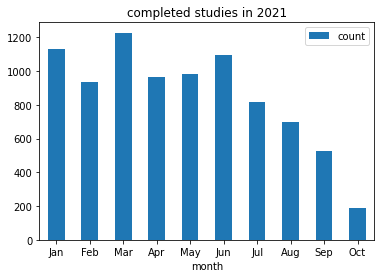

In [0]:
print(bold + '<< Number of completed studies per each month in ' + yearOfStudy + ' >>' + bold_end)
return_df = compeletedStudies(clinicaltiral)
return_df.show(truncate=False) 
myDG = return_df.toPandas()
myDG.plot.bar(x='month', y='count' , title='completed studies in ' + yearOfStudy , rot=0)

# Task 7 - Extra Question
**The number of different companies which they had penalty, and plotting the trend in a 10 years period from 2011 to 2020**

In [0]:
import pyspark.sql.functions as func
temp = pharma.filter(pharma.Penalty_Year>='2011').filter(pharma.Penalty_Year<='2020')
result = temp.groupBy('Penalty_Year').agg(func.countDistinct('Company')).orderBy('Penalty_Year') \
         .withColumnRenamed('count(''Company'')','Companies_Had_Penalty')
result.display()

Penalty_Year,Companies_Had_Penalty
2011,59
2012,53
2013,64
2014,42
2015,35
2016,37
2017,36
2018,27
2019,43
2020,28
